In [1]:
import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np
from IPython.display import HTML, display, SVG

import pydot
from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, BasicVector,
                        Parser, Saturation, Simulator, PlanarSceneGraphVisualizer, 
                        LinearQuadraticRegulator, AbstractValue, MeshcatVisualizerCpp, 
                        StartMeshcat, WrapToSystem, SceneGraph)    

from pydrake.systems.primitives import LogVectorOutput, ConstantVectorSource

from pydrake.systems.framework import LeafSystem
from pydrake.multibody import inverse_kinematics
from pydrake.multibody import plant as plnt
from pydrake.multibody import math as m
from pydrake.multibody.tree import MultibodyForces, UniformGravityFieldElement

from pydrake.multibody.plant import ContactResults
from pydrake.autodiffutils import AutoDiffXd, InitializeAutoDiff, ExtractGradient
from underactuated.meshcat_cpp_utils import MeshcatSliders, MeshcatJointSliders
from Custom_LeafSystems import *

from tqdm import tqdm as tqdm

from Linearize import getGradients

from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


<ipython-input-3-cfa5e74235a9>:7: DrakeDeprecationWarning: MeshcatVisualizerCpp has been renamed to MeshcatVisualizer. The deprecated code will be removed from Drake on or after 2022-11-01.
  vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)


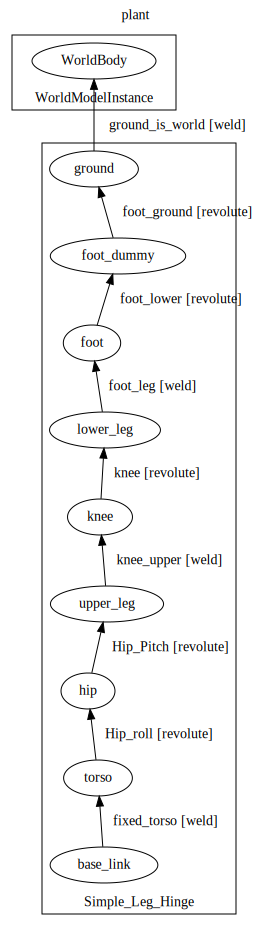

In [3]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
leg_instance = Parser(plant).AddModelFromFile("HoppingLeg/leg_v2/urdf/LEG_002_Foot_Hinge_Simple.urdf")
plant.Finalize()

meshcat.Delete()
vis = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

context = plant.CreateDefaultContext()
x0 = np.zeros(plant.num_continuous_states())
context.get_mutable_continuous_state_vector().SetFromVector(x0)

plant.get_actuation_input_port().FixValue(context, np.zeros(plant.num_actuators()))

display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))


In [4]:
# Write mathematical program to get center of gravity above foot (test how to do mathematical programs)

floating = plant.GetFloatingBaseBodies()
print(floating)

prog = MathematicalProgram()

plant_f = plant
context_f = plant_f.CreateDefaultContext()

plant_ad = plant.ToAutoDiffXd()
context_ad = plant_ad.CreateDefaultContext()

def getCoM(q):

    if q.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad

    plant.SetPositions(context, leg_instance, q)
    CoM = plant.CalcCenterOfMassPositionInWorld(context)[0:2]
    return CoM.dot(CoM)


x_init = np.array([0.5, 0, -1.31, 0.77, 0])

q = prog.NewContinuousVariables(plant.num_positions(), "q")
prog.AddCost(getCoM, vars=q)
prog.AddConstraint(q[0] >= 0.05), prog.AddConstraint(q[0] <= np.pi/2)
# prog.AddConstraint(q[2] != 0, q[2] > -np.pi/2, q[2] < np.pi/2)
prog.AddConstraint(q[2] >= -np.pi/2), prog.AddConstraint(q[2] <= -0.05)
prog.AddConstraint(q[3] >= -np.pi/2), prog.AddConstraint(q[3] <= np.pi/2)

result = Solve(prog, initial_guess=x_init)
x_pose = result.GetSolution(q)

print(x_pose)
print(f'Solution found? {result.is_success()}.')

del prog, q

state_pose = np.hstack((x_pose, np.zeros(plant_f.num_velocities())))

context_f.get_mutable_continuous_state_vector().SetFromVector(state_pose)

state_pose_auto = InitializeAutoDiff(state_pose)
context_ad.get_mutable_continuous_state_vector().SetFromVector(state_pose_auto)

# Write mathematical program to get torques for optimized position

prog = MathematicalProgram()
acc = prog.NewContinuousVariables(plant.num_velocities(), "accelerations")
vel = prog.NewContinuousVariables(plant.num_velocities(), "velocities")
torques = prog.NewContinuousVariables(plant.num_actuators(), "torques")

B = plant.MakeActuationMatrix()

def getAcceleration(vars):

    split_at = [plant_f.num_actuators(), plant_f.num_actuators() + plant_f.num_velocities()]
    tau, acc, vel = np.split(vars, split_at)
    
    if tau.dtype == float:
        plant = plant_f
        context = context_f
    else:
        plant = plant_ad
        context = context_ad 

    plant.SetPositions(context, state_pose_auto[:plant.num_positions()])
    plant.SetVelocities(context, vel)
    plant.get_actuation_input_port().FixValue(context, tau)

    # M, Cv, taug
    M = plant.CalcMassMatrixViaInverseDynamics(context)
    Cv = plant.CalcBiasTerm(context)
    taug = plant.CalcGravityGeneralizedForces(context)

    # print(M @ acc + Cv - taug - B @ tau)

    # print(plant.GetPositionsAndVelocities(context))

    return M @ acc + Cv - taug - B @ tau

vars = np.concatenate((torques, acc, vel))
prog.AddConstraint(getAcceleration, lb=[0]*plant.num_velocities(), ub=[0]*plant.num_velocities(), vars=vars)
for accs in acc: prog.AddConstraint(accs == 0)
for vels in vel: prog.AddConstraint(vels == 0)
prog.AddCost(acc.dot(acc))
# prog.AddCost(torques.dot(torques))

plant.SetPositionsAndVelocities(context, state_pose)
B_guess = plant.MakeActuationMatrix()

taug_guess = plant.CalcGravityGeneralizedForces(context)

tau = -np.linalg.pinv(B_guess) @ taug_guess
print(tau)

guess = np.zeros(2*plant.num_positions())
guess = np.hstack((guess, tau))

result = Solve(prog, initial_guess=guess)
print(result.GetSolution(torques))
# print(result.GetSolution(acc))
torque_test = result.GetSolution(torques)
print(f'Solution found? {result.is_success()}.')

# input = builder.AddSystem(ConstantVectorSource(torque_test))
# builder.Connect(input.get_output_port(), plant.get_actuation_input_port())

# print(dir(plant))

def getTorquesHoppingLeg():
    path = "HoppingLeg/leg_v2/urdf/LEG_002_Foot_Hinge_Simple.urdf"
    eq_state = state_pose
    eq_input = torque_test
    sys_autodiff = getGradients(eq_state, eq_input, path)
    sys_autodiff.makePlantFromURDF()
    sys_autodiff.getGradients()

    Q = np.eye(10)
    Q[0, 0], Q[1,1], Q[2, 2] = 10., 10., 10. 
    
    R = np.eye(3)

    K, S = LinearQuadraticRegulator(sys_autodiff.A, sys_autodiff.B, Q, R)
    return K, sys_autodiff.A, sys_autodiff.B

lqr_gain, A, B = getTorquesHoppingLeg()
# print(A, B)
print(np.linalg.eigvals(A-B@lqr_gain))

del prog, torques, acc, vel, vars

LQR_sys = builder.AddSystem(LQR_system(plant, plant.num_continuous_states(), plant.num_actuators(), lqr_gain))
des_pose = builder.AddSystem(ConstantVectorSource(state_pose))
tau_vector = builder.AddSystem(ConstantVectorSource(torque_test))

builder.Connect(plant.get_state_output_port(), LQR_sys.get_input_port(0))
builder.Connect(des_pose.get_output_port(), LQR_sys.get_input_port(1))
builder.Connect(LQR_sys.get_output_port(), plant.get_actuation_input_port())
builder.Connect(tau_vector.get_output_port(), LQR_sys.get_input_port(2))

diagram = builder.Build()

set()
[ 0.50613565  0.         -1.30527312  0.77161241  0.        ]
Solution found? True.
[0.4672507  0.00634469 0.        ]
[0.4672507  0.00634469 0.        ]
Solution found? False.
[-1.42954081e+03+0.j         -1.90643783e+02+0.j
 -1.15883144e+03+0.j         -3.17737260e+00+0.j
 -5.30712070e+00+0.18078298j -5.30712070e+00-0.18078298j
 -1.10063193e+00+0.j         -1.13736670e+00+0.j
 -5.62889502e+00+0.09601857j -5.62889502e+00-0.09601857j]


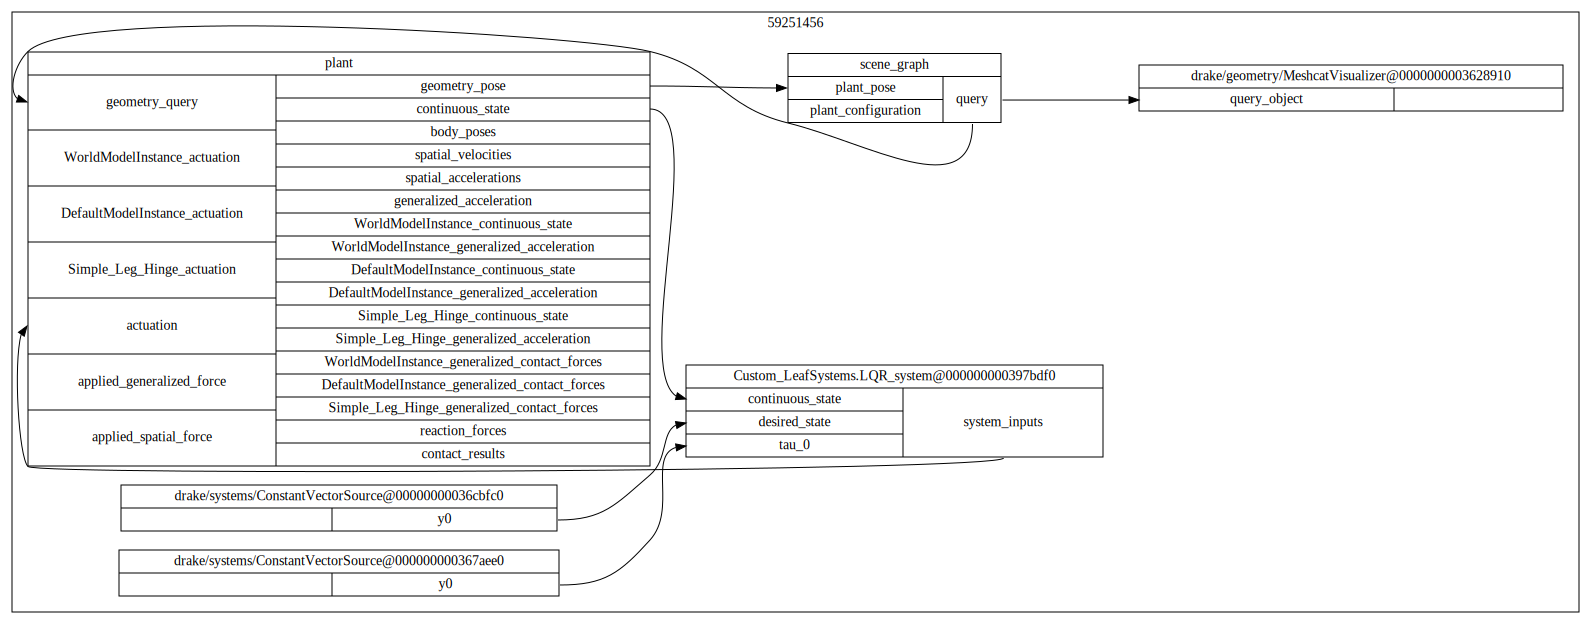

In [5]:
display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

def PoseOptimization():
    context_diagram = diagram.CreateDefaultContext()
    plant_context_from_diagram = diagram.GetSubsystemContext(plant, context_diagram)

    sliders = MeshcatJointSliders(meshcat, plant, context_diagram)
    sliders.Run(vis, context_diagram)
    meshcat.DeleteAddedControls()
    meshcat.Delete()

# PoseOptimization()

In [6]:

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
sim_context = simulator.get_mutable_context()

# Set the initial conditions (x, theta, xdot, thetadot)
sim_context.SetTime(0.)
state = np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]) # 1: foot, 2: knee, 3: hip, 4: rail x?, 5: rail y?
state = np.zeros(10)

nr_poses = 100
eq_poses = np.tile(state_pose, (nr_poses, 1))
np.random.seed(5)
rand_pose = np.random.randn(nr_poses, plant.num_positions())

rand_state = np.hstack((rand_pose, np.zeros((nr_poses, plant.num_velocities()))))
rand_state = rand_state * 0.1 * np.ones(plant.num_positions() + plant.num_velocities())
poses = eq_poses + rand_state

simulator.set_target_realtime_rate(0.0)
balanced = []

import time
time_sim = 10

for pose in tqdm(poses):

    unstable = False
    sim_context.SetContinuousState(pose)
    try:
        # vis.StartRecording()
        # time.sleep(2)
        simulator.Initialize()
        simulator.AdvanceTo(sim_context.get_time() + time_sim)
    except TimeoutError:
        balanced.append([pose, "Not stable"])
        unstable = True

    # vis.StopRecording()
    if not unstable: balanced.append([pose, "stable"])

    sim_context.SetTime(0.0)

# vis.PublishRecording()

stable_poses = []
for i in range(len(balanced)): 
    if balanced[i][1] == "stable": stable_poses.append(balanced[i][0])

dev = np.array(stable_poses) - np.tile(state_pose, (len(stable_poses), 1))

dev = np.diagonal(dev.dot(dev.T))
index_max_dev = np.argmax(dev)

print(stable_poses[index_max_dev])

simulator.Initialize()
sim_context.SetContinuousState(stable_poses[index_max_dev])
sim_context.SetTime(0.0)
vis.StartRecording()
simulator.AdvanceTo(sim_context.get_time() + time_sim)
vis.StopRecording()
vis.PublishRecording()

meshcat.DeleteAddedControls()

plt.style.use("ggplot")
plt.rcParams["font.family"] = "sans-serif"
sns.set_palette("dark")
sns.set_context("talk")

# t = np.arange(0, len(torques[1]))
# print(len(t))

# plt.plot(t, CoMs.flatten(), label="CoM y")
# plt.legend()
# plt.title("Center of mass position y")
# plt.xlabel("Time step")
# plt.ylabel("position [m]")
# plt.tight_layout()
# plt.show()

# plt.plot(t, torques[0, :], label="knee")
# plt.plot(t, torques[1, :], label="hip")
# plt.legend()
# plt.title("torques")
# plt.xlabel("Time step")
# plt.ylabel("toruqe [Nm]")
# plt.tight_layout()
# plt.show()

# plt.plot(t, torques[2, :], label="rail z")
# plt.plot(t, torques[3, :], label="rail y")
# plt.legend()
# plt.title("forces")
# plt.xlabel("Time step")
# plt.ylabel("Force [N]")
# plt.tight_layout()
# plt.show()

# TODO: Add to slides LQR via inverse dynamics or LQR via contraints (Problem formulation)
# Idea for slides: Obtaining pose / trajectory
# DFKI robot squatting
# Remove Intro slide
# Introduce Leg

100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


[ 0.43778309 -0.00189981 -1.21370686  0.90748313  0.06044377  0.
  0.          0.          0.          0.        ]
